In [1]:
base_jsonl_path = "/home/yb107/cvpr2025/DukeDiffSeg/data/mobina_mixed_colon_dataset/mobina_mixed_colon_dataset_with_body_filled.jsonl"
train_jsonl_path = "/home/yb107/cvpr2025/DukeDiffSeg/data/mobina_mixed_colon_dataset/mobina_mixed_colon_dataset_with_body_filled_train.jsonl"
val_jsonl_path = "/home/yb107/cvpr2025/DukeDiffSeg/data/mobina_mixed_colon_dataset/mobina_mixed_colon_dataset_with_body_filled_val.jsonl"
test_jsonl_path = "/home/yb107/cvpr2025/DukeDiffSeg/data/mobina_mixed_colon_dataset/mobina_mixed_colon_dataset_with_body_filled_test.jsonl"
organ_vol_csv = "/home/yb107/cvpr2025/DukeDiffSeg/data/organ_vol_dukesegv1.csv"

import pandas as pd
import json
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly


def load_jsonl(jsonl_path):
    data = []
    with open(jsonl_path, "r") as f:
        for line in f:
            data.append(json.loads(line)["mask"])
    return data


def load_liver_volumes(jsonl_path):
    data_paths = load_jsonl(jsonl_path)
    file_names = [i.split("/")[-1].split(".")[0] for i in data_paths]

    # forach file name, get the liver volume df["patient_id"] == file_name]["liver_vol"]
    liver_vol_dict = defaultdict(float)
    for file_name in file_names:
        liver_vol = df[df["patient_id"] == file_name]["liver"]
        if not liver_vol.empty:
            liver_vol_dict[file_name] = liver_vol.values[0]
        else:
            filename = "_".join(file_name.split("_")[:-1])
            liver_vol = df[df["patient_id"] == filename]["liver"]
            if not liver_vol.empty:
                liver_vol_dict[file_name] = liver_vol.values[0]
            else:
                print(f"No liver volume found for {filename}")

    return liver_vol_dict


def plot_histogram(liver_vol, title="Liver Volume Distribution"):
    plt.figure(figsize=(10, 6))
    sns.histplot(list(liver_vol.values()), bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Liver Volume (cm³)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


def load_organ_vol_csv(csv_path):
    return pd.read_csv(csv_path)


df = load_organ_vol_csv(organ_vol_csv)

all_liver_vol_dict = load_liver_volumes(base_jsonl_path)
train_liver_vol_dict = load_liver_volumes(train_jsonl_path)
val_liver_vol_dict = load_liver_volumes(val_jsonl_path)
test_liver_vol_dict = load_liver_volumes(test_jsonl_path)

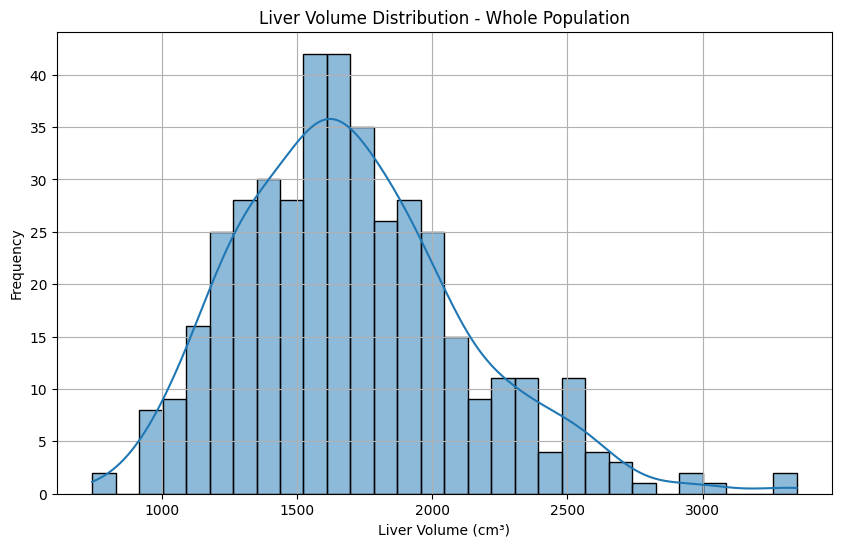

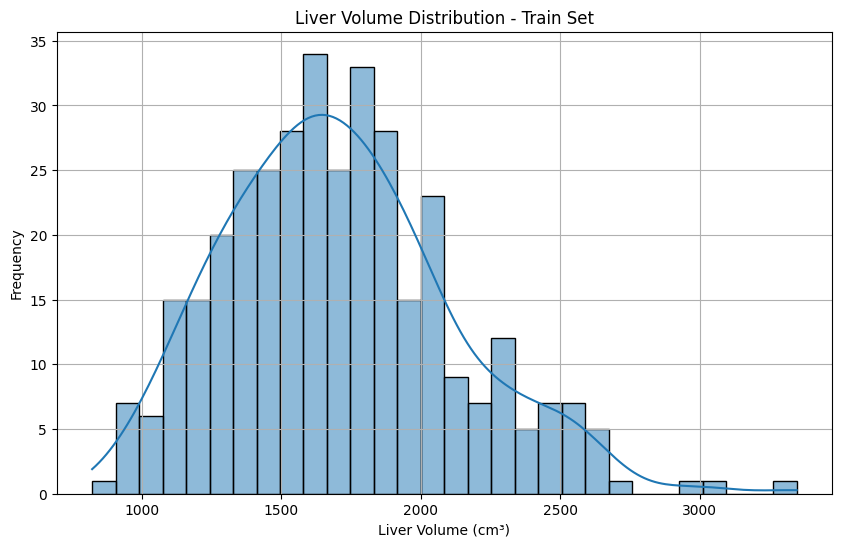

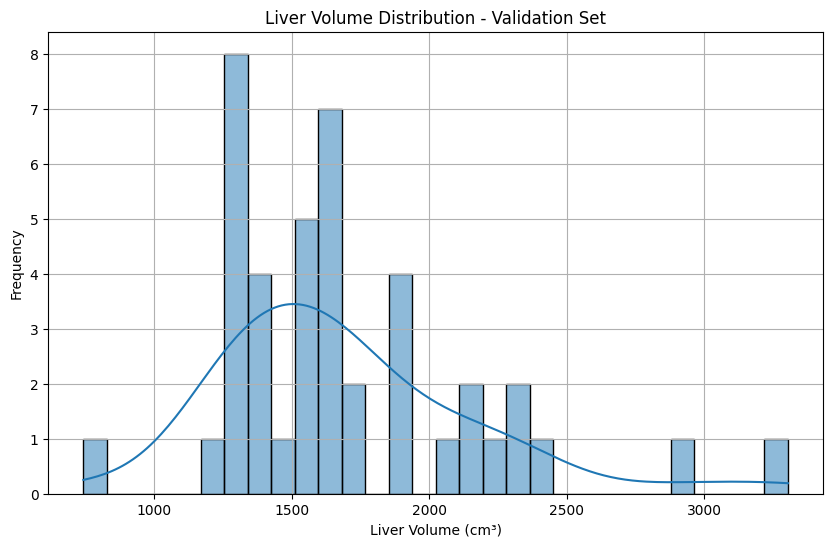

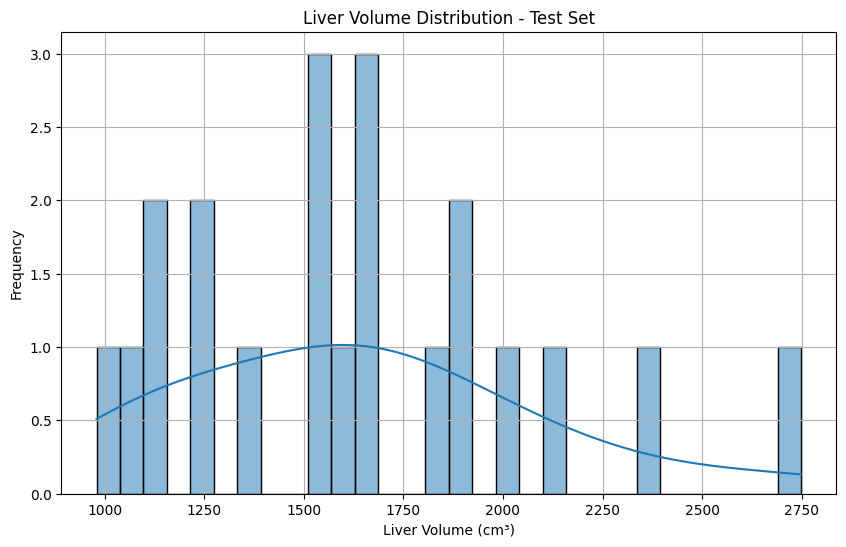

In [2]:
# plot histogram of liver volumes
plot_histogram(all_liver_vol_dict, title="Liver Volume Distribution - Whole Population")
plot_histogram(train_liver_vol_dict, title="Liver Volume Distribution - Train Set")
plot_histogram(val_liver_vol_dict, title="Liver Volume Distribution - Validation Set")
plot_histogram(test_liver_vol_dict, title="Liver Volume Distribution - Test Set")

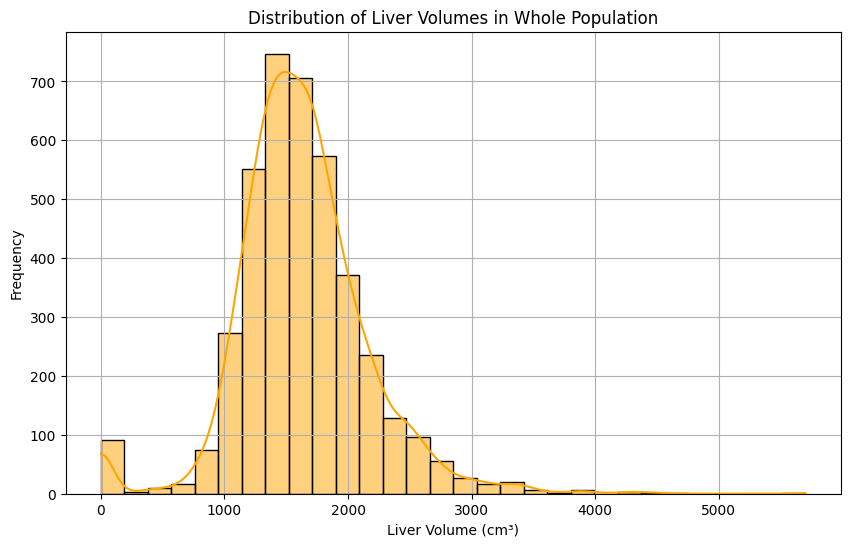

In [3]:
# plot the liver volumes for the whole popoulation
whole_population_liver_vols = df["liver"].values
plt.figure(figsize=(10, 6))
sns.histplot(whole_population_liver_vols, bins=30, kde=True, color="orange")
plt.title("Distribution of Liver Volumes in Whole Population")
plt.xlabel("Liver Volume (cm³)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [4]:
whole_population_liver_vols_mean = np.mean(whole_population_liver_vols)
whole_population_liver_vols_std = np.std(whole_population_liver_vols)
print(f"Mean Liver Volume (Whole Population): {whole_population_liver_vols_mean}")
print(f"STD of Liver Volume (Whole Population): {whole_population_liver_vols_std}")

Mean Liver Volume (Whole Population): 1625.4513708138581
STD of Liver Volume (Whole Population): 535.5121956754056


In [4]:
# Divide the whole population liver volumes into 4 bins and print the range of each bin
bins = np.percentile(whole_population_liver_vols, [0, 25, 50, 75, 100])
for i in range(len(bins) - 1):
    print(f"Bin {i + 1}: {bins[i]:.2f} - {bins[i + 1]:.2f} cm³")

Bin 1: 0.00 - 1327.81 cm³
Bin 2: 1327.81 - 1589.99 cm³
Bin 3: 1589.99 - 1888.22 cm³
Bin 4: 1888.22 - 5701.08 cm³


In [17]:
import nibabel as nib
import numpy as np


example_path = "/data/usr/yb107/colon_data/refined_by_mobina/a_grade_colons_not_in_refined_by_md/masks/Patient_00426_Study_24513_Series_03.nii.gz"
img = nib.load(example_path)
data = img.get_fdata()
liver = data == 5  # assuming liver label is 5
liver_volume = np.sum(liver) * (1.5 * 1.5 * 2.0)  # voxel size in mm³
liver_volume_cm3 = liver_volume / 1000.0  # convert to cm³
print(f"Liver Volume: {liver_volume_cm3} cm³")

Liver Volume: 3306.465 cm³


In [24]:
import torch
import torch.nn.functional as F


def zoom_sdf_advanced(sdf, zoom_factor=1.5, extrapolation_mode="max"):
    """
    Advanced SDF zoom with smart extrapolation

    Args:
        extrapolation_mode:
            'max' = use maximum SDF value (far from surface)
            'linear' = linear extrapolation from border
            'constant' = use specific value
            'reflect' = reflect border values
    """

    if sdf.ndim == 4:
        sdf = sdf.unsqueeze(0)
        squeeze_after = True
    else:
        squeeze_after = False

    B, C, H, W, D = sdf.shape
    device = sdf.device

    # Determine extrapolation value
    if extrapolation_mode == "max":
        extrap_value = sdf.max().item()
    elif extrapolation_mode == "min":
        extrap_value = sdf.min().item()
    elif isinstance(extrapolation_mode, (int, float)):
        extrap_value = extrapolation_mode
    else:
        extrap_value = None

    # Apply zoom using affine grid
    if isinstance(zoom_factor, (int, float)):
        zoom_factor = [zoom_factor] * 3

    # Create affine transformation matrix
    theta = torch.tensor(
        [
            [1 / zoom_factor[0], 0, 0, 0],
            [0, 1 / zoom_factor[1], 0, 0],
            [0, 0, 1 / zoom_factor[2], 0],
        ],
        dtype=torch.float32,
        device=device,
    )

    theta = theta.unsqueeze(0).expand(B, -1, -1)  # [B, 3, 4]

    # Generate sampling grid
    grid = F.affine_grid(theta, sdf.shape, align_corners=True)

    # Sample with appropriate padding mode
    padding_modes = {
        "max": "border",
        "min": "border",
        "reflect": "reflection",
        "zeros": "zeros",
    }
    padding_mode = padding_modes.get(extrapolation_mode, "border")

    zoomed = F.grid_sample(
        sdf, grid, mode="bilinear", padding_mode=padding_mode, align_corners=True
    )

    # Rescale SDF distances
    avg_zoom = sum(zoom_factor) / len(zoom_factor)
    zoomed = zoomed * avg_zoom

    # Apply custom extrapolation if needed
    if extrap_value is not None and extrapolation_mode in ["max", "min"]:
        # Detect out-of-bounds regions
        out_of_bounds = (
            (grid[..., 0].abs() > 1)
            | (grid[..., 1].abs() > 1)
            | (grid[..., 2].abs() > 1)
        )
        out_of_bounds = out_of_bounds.unsqueeze(1).expand_as(zoomed)

        # Blend smoothly near boundaries
        border_distance = torch.min(
            torch.stack(
                [
                    1 - grid[..., 0].abs(),
                    1 - grid[..., 1].abs(),
                    1 - grid[..., 2].abs(),
                ],
                dim=-1,
            ),
            dim=-1,
        )[0]

        blend_region = (border_distance < 0.1) & (border_distance > 0)
        blend_weight = (border_distance / 0.1).clamp(0, 1)
        blend_weight = blend_weight.unsqueeze(1).expand_as(zoomed)

        # Smooth transition to extrapolation value
        zoomed = torch.where(
            out_of_bounds, torch.full_like(zoomed, extrap_value), zoomed
        )

        # Blend at boundaries
        zoomed = torch.where(
            blend_region.unsqueeze(1).expand_as(zoomed),
            zoomed * blend_weight + extrap_value * (1 - blend_weight),
            zoomed,
        )

    if squeeze_after:
        zoomed = zoomed.squeeze(0)

    return zoomed

In [1]:
test_jsonl_path = "/home/yb107/cvpr2025/DukeDiffSeg/data/mobina_mixed_colon_dataset/mobina_mixed_colon_dataset_with_body_filled_test.jsonl"
import json


def load_jsonl_inference(jsonl_path):
    data = []
    with open(jsonl_path, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data


test_data = load_jsonl_inference(test_jsonl_path)
test_data = test_data[0]

In [ ]:
# Cell 1: Setup
from inference_notebook import *

config = InferenceConfig()
config.checkpoint_path = "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-iterative/7.2/DiffUnet-binary-iterative_liver_latest_checkpoint_97.pt"
config.device = "cuda:1"
config.model_mean_type = "epsilon"

# 1. Preprocess
print("📦 Preprocessing data...")
transform = build_inference_transform(
    config, "liver", [5, 12, 6, 7, 4, 9, 11, 10, 2, 1, 3]
)

data_dict = {
    "image": test_data["mask"],
    "label": test_data["mask"],
    "body_filled_channel": test_data["body_filled_mask"],
}
print("🏋️‍♀️ Applying transforms...")
# data_dict = transform(data_dict)

📦 Preprocessing data...
🏋️‍♀️ Applying transforms...


/home/yb107/.local/share/virtualenvs/DukeDiffSeg-HooVw7aP/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [6]:
import torch


# SAVE data_dict as .pt for caching
# torch.save(data_dict, "tmp/data_dict.pt")

# load data_dict from .pt
data_dict = torch.load("tmp/data_dict.pt", weights_only=False)

In [12]:
label = data_dict["label"]
label = label > 0
print(label.unique())
# Calculate original liver volume
original_liver_volume = (label == 1).sum().item() * (
    1.5 * 1.5 * 2.0
)  # assuming 1.5mm^3 voxel size
# mm³ to cm³
original_liver_volume = original_liver_volume / 1000.0
print(f"Original Liver Volume: {original_liver_volume} cm³")

metatensor([False,  True])
Original Liver Volume: 183.3255 cm³


In [4]:
torch.manual_seed(69)
from monai.networks.schedulers import DDPMScheduler

ddpm_scheduler = DDPMScheduler(
    num_train_timesteps=config.diffusion_steps,
    beta_start=0.0001,
    beta_end=0.02,
    schedule=config.beta_schedule,
    clip_sample=False,
    prediction_type=config.model_mean_type,
)
ddpm_scheduler.set_timesteps(num_inference_steps=5)

In [4]:
# 2. Build model & scheduler
print("🏗️  Building model...")
model = build_model(config)
scheduler = build_scheduler(config)

🏗️  Building model...
✓ Model loaded from /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-iterative/6.6/checkpoints/liver/DiffUnet-binary-iterative_liver_best_checkpoint_1710_MeanDice0.7490.pt
✓ Parameters: 29.11M


In [ ]:
image_sdf = data_dict["image"].unsqueeze(0)  # [1, 1, H, W, D]
label_sdf = data_dict["label"].unsqueeze(0)
body_filled_sdf = data_dict["body_filled_channel"].unsqueeze(0)
spacing = data_dict["spacing_tensor"]

In [52]:
zoomed_out_body_filled_sdf = zoom_sdf_advanced(
    body_filled_sdf, zoom_factor=1.7, extrapolation_mode="linear"
)

In [53]:
print("🎨 Running DDIM sampling...")
pred_mask, pred_sdf = run_inference(
    model, scheduler, image_sdf, zoomed_out_body_filled_sdf, config
)

🎨 Running DDIM sampling...
Step 0: t=950, change=0.010081, pred_mean=-0.0101
Step 1: t=900, change=0.013949, pred_mean=-0.0235
Step 2: t=850, change=0.018894, pred_mean=-0.0411
Step 3: t=800, change=0.025337, pred_mean=-0.0629
Step 4: t=750, change=0.033894, pred_mean=-0.0889
  Step 5/20
Step 5: t=700, change=0.044959, pred_mean=-0.1187
Step 6: t=650, change=0.058530, pred_mean=-0.1514
Step 7: t=600, change=0.074019, pred_mean=-0.1859
Step 8: t=550, change=0.090441, pred_mean=-0.2207
Step 9: t=500, change=0.106507, pred_mean=-0.2547
  Step 10/20
Step 10: t=450, change=0.120876, pred_mean=-0.2864
Step 11: t=400, change=0.132359, pred_mean=-0.3149
Step 12: t=350, change=0.140071, pred_mean=-0.3395
Step 13: t=300, change=0.143505, pred_mean=-0.3599
Step 14: t=250, change=0.142542, pred_mean=-0.3759
  Step 15/20
Step 15: t=200, change=0.137431, pred_mean=-0.3879
Step 16: t=150, change=0.128858, pred_mean=-0.3965
Step 17: t=100, change=0.118905, pred_mean=-0.4026
Step 18: t=50, change=0.137

In [54]:
# Compute sum of the pred_mask
pred_sum = pred_mask.sum().item()
label_sum = (label_sdf > 0).sum().item()
print(f"Sum of predicted mask: {pred_sum}")
print(f"Sum of label mask: {label_sum}")

Sum of predicted mask: 29603.0
Sum of label mask: 40739


In [55]:
monai.transforms.SaveImage(
    output_dir="tmp/",
    output_postfix="_pred_smallest",
    separate_folder=False,
)(pred_mask.squeeze(0))
# monai.transforms.SaveImage(
#     output_dir="tmp/",
#     output_postfix="_pred_sdf",
#     separate_folder=False,
# )(pred_sdf.squeeze(0))
# monai.transforms.SaveImage(
#     output_dir="tmp/",
#     output_postfix="_img_sdf",
#     separate_folder=False,
# )(label_sdf.squeeze(0))
# monai.transforms.SaveImage(
#     output_dir="tmp/",
#     output_postfix="_zoom_body_filled_sdf",
#     separate_folder=False,
# )(zoomed_out_body_filled_sdf.squeeze(0))

2025-11-05 22:09:13,806 INFO image_writer.py:197 - writing: tmp/Patient_00074_Study_78614_Series_03__pred_smallest.nii.gz


metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [ ]:
import numpy as np
import torch
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize_3d
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path


def split_colon_into_3_sections(binary_mask, method="spatial", device="cpu"):
    """
    Convert binary colon segmentation mask into 3-channel tensor with separate sections.

    Args:
        binary_mask: torch.Tensor or np.ndarray of shape [D, H, W] or [H, W, D]
                     Binary mask with 0=background, 1=colon
        method: str, either 'spatial' (faster) or 'skeleton' (more accurate)
        device: str, torch device for output tensor

    Returns:
        torch.Tensor of shape [3, D, H, W] where:
            channel 0: proximal section
            channel 1: middle section
            channel 2: distal section
    """

    # Convert to numpy if torch tensor
    if torch.is_tensor(binary_mask):
        mask_np = binary_mask.cpu().numpy()
    else:
        mask_np = binary_mask

    # Ensure binary
    mask_np = (mask_np > 0).astype(np.uint8)

    if method == "spatial":
        three_channel_mask = _split_spatial(mask_np)
    elif method == "skeleton":
        three_channel_mask = _split_skeleton(mask_np)
    else:
        raise ValueError(f"Method must be 'spatial' or 'skeleton', got {method}")

    # Convert to torch tensor [3, D, H, W]
    output_tensor = torch.from_numpy(three_channel_mask).float().to(device)

    return output_tensor


def _split_spatial(mask_np):
    """
    Split mask into 3 sections based on dominant spatial axis (faster method).
    """
    # Find colon voxels
    colon_coords = np.argwhere(mask_np > 0)

    if len(colon_coords) == 0:
        # Empty mask, return empty 3-channel
        return np.zeros((3, *mask_np.shape), dtype=np.float32)

    # Find principal axis using PCA
    centered = colon_coords - colon_coords.mean(axis=0)
    cov_matrix = np.cov(centered.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]

    # Project coordinates onto principal axis
    projections = colon_coords @ principal_axis

    # Divide into thirds based on projection values
    percentile_33 = np.percentile(projections, 33.33)
    percentile_66 = np.percentile(projections, 66.67)

    # Create 3-channel output
    three_channel = np.zeros((3, *mask_np.shape), dtype=np.float32)

    for i, coord in enumerate(colon_coords):
        proj_val = projections[i]
        if proj_val < percentile_33:
            channel = 0  # Proximal
        elif proj_val < percentile_66:
            channel = 1  # Middle
        else:
            channel = 2  # Distal

        three_channel[channel, coord[0], coord[1], coord[2]] = 1.0

    return three_channel


def _split_skeleton(mask_np):
    """
    Split mask into 3 sections based on centerline skeleton (more accurate).
    """
    # Find largest connected component
    from scipy.ndimage import label

    labeled, num_features = label(mask_np)

    if num_features == 0:
        return np.zeros((3, *mask_np.shape), dtype=np.float32)

    # Get largest component
    if num_features > 1:
        sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]
        largest_label = np.argmax(sizes) + 1
        mask_np = (labeled == largest_label).astype(np.uint8)

    # Extract skeleton
    skeleton = skeletonize_3d(mask_np)
    skeleton_coords = np.argwhere(skeleton)

    if len(skeleton_coords) < 3:
        # Fallback to spatial method if skeleton too small
        return _split_spatial(mask_np)

    # Order skeleton points along path
    ordered_skeleton = _order_skeleton_points(skeleton_coords)

    # Divide into thirds
    n = len(ordered_skeleton)
    section_1 = ordered_skeleton[: n // 3]
    section_2 = ordered_skeleton[n // 3 : 2 * n // 3]
    section_3 = ordered_skeleton[2 * n // 3 :]

    # Build KD-trees for each section
    tree_1 = cKDTree(section_1)
    tree_2 = cKDTree(section_2)
    tree_3 = cKDTree(section_3)

    # Get all colon voxels
    colon_coords = np.argwhere(mask_np > 0)

    # Create 3-channel output
    three_channel = np.zeros((3, *mask_np.shape), dtype=np.float32)

    # Assign each voxel to nearest section
    for coord in colon_coords:
        dist_1 = tree_1.query(coord)[0]
        dist_2 = tree_2.query(coord)[0]
        dist_3 = tree_3.query(coord)[0]

        distances = [dist_1, dist_2, dist_3]
        nearest_section = np.argmin(distances)

        three_channel[nearest_section, coord[0], coord[1], coord[2]] = 1.0

    return three_channel


def _order_skeleton_points(skeleton_coords):
    """
    Order skeleton points along the path from one end to the other.
    """
    n = len(skeleton_coords)

    if n < 2:
        return skeleton_coords

    # Build distance matrix (use sparse for efficiency)
    tree = cKDTree(skeleton_coords)

    # For each point, find k nearest neighbors (k=5 for colon topology)
    k = min(5, n)
    distances, indices = tree.query(skeleton_coords, k=k)

    # Build adjacency matrix
    rows = np.repeat(np.arange(n), k)
    cols = indices.flatten()
    data = distances.flatten()

    adj_matrix = csr_matrix((data, (rows, cols)), shape=(n, n))

    # Find endpoints (points with only 1-2 neighbors within small distance)
    threshold = np.percentile(
        distances[:, 1], 25
    )  # 25th percentile of nearest neighbor distances
    degree = (distances < threshold * 1.5).sum(axis=1)

    endpoints = np.where(degree <= 2)[0]

    if len(endpoints) < 2:
        # No clear endpoints, just use furthest points
        endpoints = [0, n - 1]

    # Compute shortest path from first to last endpoint
    start_idx = endpoints[0]

    # Find furthest endpoint from start
    distances_from_start = shortest_path(adj_matrix, indices=start_idx)
    valid_endpoints = [ep for ep in endpoints if np.isfinite(distances_from_start[ep])]

    if len(valid_endpoints) < 2:
        # Fallback: use simple ordering
        return skeleton_coords

    end_idx = valid_endpoints[
        np.argmax([distances_from_start[ep] for ep in valid_endpoints])
    ]

    # Get shortest path
    _, predecessors = shortest_path(
        adj_matrix, indices=start_idx, return_predecessors=True
    )

    # Reconstruct path
    path = []
    current = end_idx
    while current != -9999 and current != start_idx:
        path.append(current)
        current = predecessors[current]
        if current == -9999:
            break

    path.append(start_idx)
    path = path[::-1]

    if len(path) < n // 2:
        # Path reconstruction failed, fallback to spatial ordering
        projections = skeleton_coords @ skeleton_coords.mean(axis=0)
        sorted_indices = np.argsort(projections)
        return skeleton_coords[sorted_indices]

    return skeleton_coords[path]


# Example usage
if __name__ == "__main__":
    # Example with synthetic data
    print("Testing with synthetic colon mask...")

    # Create a simple tubular structure
    mask = np.zeros((64, 64, 64), dtype=np.uint8)
    for z in range(10, 55):
        y = 32 + int(5 * np.sin(z / 10))
        x = 32 + int(5 * np.cos(z / 10))
        mask[z, y - 3 : y + 3, x - 3 : x + 3] = 1

    # Convert to torch
    mask_tensor = torch.from_numpy(mask).float()

    print(f"Input mask shape: {mask_tensor.shape}")
    print(f"Total colon voxels: {mask_tensor.sum().item()}")

    # Split using spatial method (faster)
    output_spatial = split_colon_into_3_sections(mask_tensor, method="spatial")
    print(f"\nOutput shape: {output_spatial.shape}")
    print(f"Section 1 voxels: {output_spatial[0].sum().item()}")
    print(f"Section 2 voxels: {output_spatial[1].sum().item()}")
    print(f"Section 3 voxels: {output_spatial[2].sum().item()}")

    # Split using skeleton method (more accurate)
    output_skeleton = split_colon_into_3_sections(mask_tensor, method="skeleton")
    print(f"\nSkeleton method:")
    print(f"Section 1 voxels: {output_skeleton[0].sum().item()}")
    print(f"Section 2 voxels: {output_skeleton[1].sum().item()}")
    print(f"Section 3 voxels: {output_skeleton[2].sum().item()}")

    # Verify no overlap
    total = output_spatial.sum(dim=0)
    assert (total <= 1).all(), "Sections should not overlap!"
    print("\n✓ No overlap between sections")

    # Verify all colon voxels are assigned
    total_assigned = output_spatial.sum()
    original_voxels = mask_tensor.sum()
    print(f"✓ Coverage: {total_assigned.item()}/{original_voxels.item()} voxels")